In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
import os
from tqdm import tqdm

from model import Extractor, Classifier, Discrimimator

In [2]:
data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataS = torchvision.datasets.ImageFolder(root='./data/MNIST/train', transform=data_transform)
loader_trainS = torch.utils.data.DataLoader(train_dataS,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=4) 

test_dataS = torchvision.datasets.ImageFolder(root='./data/MNIST/test', transform=data_transform)
loader_testS = torch.utils.data.DataLoader(train_dataS,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4) 

train_dataT = torchvision.datasets.ImageFolder(root='./data/MNIST-M/train', transform=data_transform)
loader_trainT = torch.utils.data.DataLoader(train_dataT,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=4) 

test_dataT = torchvision.datasets.ImageFolder(root='./data/MNIST-M/test', transform=data_transform)
loader_testT = torch.utils.data.DataLoader(train_dataT,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4) 

In [3]:
gpu_flag = torch.cuda.is_available()

extractor1 = Extractor()
classifier1 = Classifier()
extractor2 = Extractor()
classifier2 = Classifier()

if gpu_flag:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

extractor1 = extractor1.to(device)
classifier1 = classifier1.to(device)
extractor2 = extractor2.to(device)
classifier2 = classifier2.to(device)

extractor1.eval()
classifier1.eval
extractor2.eval
classifier2.eval()

extractor1.load_state_dict(torch.load('log/extractor_source_only_55.7.pth'))
classifier1.load_state_dict(torch.load('log/classifier_source_only_55.7.pth'))
extractor2.load_state_dict(torch.load('log/extractor_dann_68.3.pth'))
classifier2.load_state_dict(torch.load('log/classifier_dann_68.3.pth'))

<All keys matched successfully>

In [4]:
def evaluate(extractor, classifier):
    cls_criterion = nn.NLLLoss()
    dom_criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD([{'params': extractor.parameters()},
                       {'params': classifier.parameters()},
                       ], lr= 0.01, momentum= 0.9)
    
    #valid
    extractor.eval()
    classifier.eval()
    running_loss = 0
    cls_cntS = 0
    cls_cntT = 0
    val_Steps = 100
    total = 0
    for batch_idx, dataS, dataT in zip(tqdm(range(val_Steps)), loader_testS, loader_testT):
        xS , yS = dataS
        xT , yT = dataT

        xS, yS = Variable(xS.to(device)), Variable(yS.to(device))
        xT, yT = Variable(xT.to(device)), Variable(yT.to(device))

        optimizer.zero_grad()

        featS = extractor(xS)
        featT = extractor(xT)

        cls_predS = classifier(featS)
        cls_lossS = cls_criterion(cls_predS, yS)  
        cls_predT = classifier(featT)
        cls_lossT = cls_criterion(cls_predT, yT)  

        loss = (cls_lossS + cls_lossT) / 2

        running_loss += loss.item()
        cls_outS= torch.argmax(cls_predS.data, dim=1)
        cls_cntS += (cls_outS == yS.data).sum()
        cls_outT= torch.argmax(cls_predT.data, dim=1)
        cls_cntT += (cls_outT == yT.data).sum()
        total += yS.size(0)

    loss_val = running_loss / val_Steps
    acc_clsS = float(cls_cntS) / total
    acc_clsT = float(cls_cntT) / total

    print("<Val>")
    print('loss: {:.2f}'.format(loss_val))
    print('Source acc: {:.2f}%, Target acc: {:.2f}%'.format(acc_clsS*100., acc_clsT*100.))

In [5]:
evaluate(extractor1, classifier1)

100%|██████████| 100/100 [00:01<00:00, 68.48it/s]


<Val>
loss: 0.75
Source acc: 96.33%, Target acc: 55.81%


In [6]:
evaluate(extractor2, classifier2)

100%|██████████| 100/100 [00:01<00:00, 68.12it/s]


<Val>
loss: 0.57
Source acc: 97.67%, Target acc: 68.91%


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from sklearn.manifold import TSNE
%matplotlib inline

In [8]:
for batch_idx, dataS, dataT in zip(tqdm(range(5)), loader_testS, loader_testT):
        xS , yS = dataS
        xT , yT = dataT

        xS, yS = Variable(xS.to(device)), Variable(yS.to(device))
        xT, yT = Variable(xT.to(device)), Variable(yT.to(device))

        featS1 = extractor1(xS)
        featT1 = extractor1(xT)
        featS2 = extractor2(xS)
        featT2 = extractor2(xT)
        
        if batch_idx==0:
            outS1 = featS1.cpu().detach().numpy().copy()
            outT1 = featT1.cpu().detach().numpy().copy()
            outS2 = featS2.cpu().detach().numpy().copy()
            outT2 = featT2.cpu().detach().numpy().copy()
            labelS = yS.cpu().detach().numpy().copy()
            labelT = yT.cpu().detach().numpy().copy()            
            
        else:
            outS1 = np.concatenate([outS1,featS1.cpu().detach().numpy().copy()])
            outT1 = np.concatenate([outT1,featT1.cpu().detach().numpy().copy()])
            outS2 = np.concatenate([outS2,featS2.cpu().detach().numpy().copy()])
            outT2 = np.concatenate([outT2,featT2.cpu().detach().numpy().copy()])
            labelS = np.concatenate([labelS, yS.cpu().detach().numpy()])
            labelT = np.concatenate([labelT, yT.cpu().detach().numpy()])            

100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


In [9]:
decomp = TSNE(n_components=2)
X_decomp1 = decomp.fit_transform(np.concatenate([outS1, outT1]))
X_decomp2 = decomp.fit_transform(np.concatenate([outS2, outT2]))

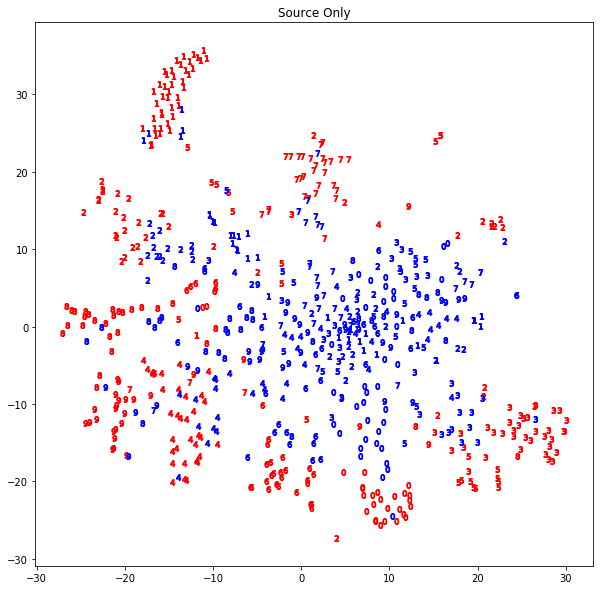

In [10]:
plt.figure(figsize=(10, 10))

for i, l in enumerate(np.concatenate([labelS, labelT])):
    marker = "$" + str(l) + "$"
    if i<320:
        plt.scatter(X_decomp1[i, 0], X_decomp1[i, 1], marker=marker, color='r')
    else:
        plt.scatter(X_decomp1[i, 0], X_decomp1[i, 1], marker=marker, color='b')
plt.title("Source Only")
plt.savefig('source_only.png')
plt.show()

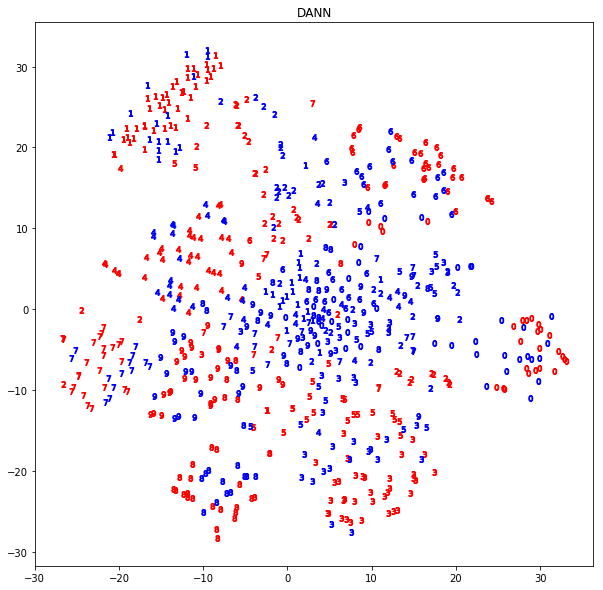

In [12]:
plt.figure(figsize=(10, 10))

for i, l in enumerate(np.concatenate([labelS, labelT])):
    marker = "$" + str(l) + "$"
    if i<320:
        plt.scatter(X_decomp2[i, 0], X_decomp2[i, 1], marker=marker, color='r')
    else:
        plt.scatter(X_decomp2[i, 0], X_decomp2[i, 1], marker=marker, color='b')
plt.title("DANN")
plt.savefig('dann.png')
plt.show()